### Exploration & Data Loading

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import mlflow
mlflow.sklearn.autolog()
mlflow.set_experiment('decision_tree_classifier')

<Experiment: artifact_location='s3://infnet-mlflow-bucket/3', creation_time=1758580682096, experiment_id='3', last_update_time=1758580682096, lifecycle_stage='active', name='decision_tree_classifier', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [3]:
path = Path.cwd().parent / "data" / "raw" / "diabetes_prediction_dataset.csv"
df = pd.read_csv(path)
df.shape

(100000, 9)

In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df.describe(include="all")

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


##### Analysing "gender" column

In [7]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

A coluna `gender` por padrão tem 3 valores únicos: Male, Female e Other. Como a quantidade de "Other" é bem reduzida perto da base de dados e não conseguimos inferir esta informação, optamos por retirar estas linhas para podermos lidar como uma coluna binária.

In [8]:
df = df.drop(df[df["gender"] == "Other"].index)
df["gender"].value_counts()


gender
Female    58552
Male      41430
Name: count, dtype: int64

### Binary Encoding

In [9]:
binary_cols = ['gender']

In [10]:
df[binary_cols] = df[binary_cols].apply(lambda col: col.map({"Male": 1, "Female": 0}))

In [11]:
df['gender'].value_counts()

gender
0    58552
1    41430
Name: count, dtype: int64

#### One-Hot encoding

In [12]:
multi_category_columns = ['smoking_history']

df = pd.get_dummies(df, columns=multi_category_columns, drop_first=True)

In [13]:
df.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,0,False,False,False,True,False
1,0,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False
2,1,28.0,0,0,27.32,5.7,158,0,False,False,False,True,False
3,0,36.0,0,0,23.45,5.0,155,0,True,False,False,False,False
4,1,76.0,1,1,20.14,4.8,155,0,True,False,False,False,False


### Correlation Matrix

In [14]:
correlation_matrix = df.corr()
diabetes_correlation = correlation_matrix['diabetes'].sort_values(ascending=False)
print(diabetes_correlation)

diabetes                       1.000000
blood_glucose_level            0.419587
HbA1c_level                    0.400696
age                            0.257999
bmi                            0.214377
hypertension                   0.197811
heart_disease                  0.171718
smoking_history_former         0.097901
gender                         0.037623
smoking_history_never          0.027248
smoking_history_ever           0.024088
smoking_history_not current    0.020831
smoking_history_current        0.019588
Name: diabetes, dtype: float64


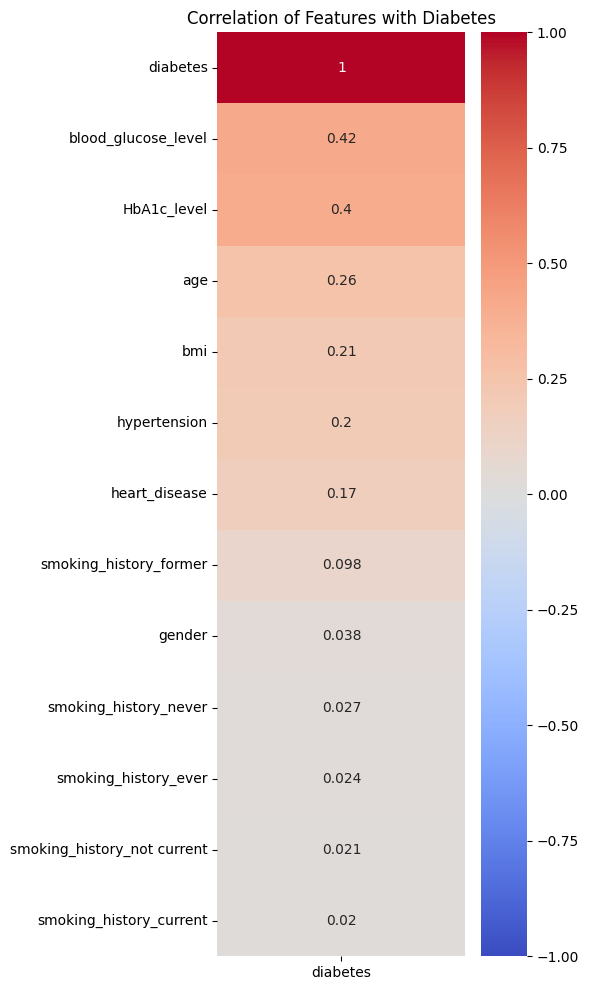

In [15]:
correlation_matrix = df.corr(numeric_only=True)

diabetes_correlation = correlation_matrix[['diabetes']].sort_values(by='diabetes', ascending=False)

plt.figure(figsize=(4, 12))
sns.heatmap(diabetes_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Features with Diabetes')
plt.show()

#### Machine Learning

In [16]:
df['diabetes'].value_counts(normalize=True)

diabetes
0    0.914985
1    0.085015
Name: proportion, dtype: float64

Claramente, podemos notar um problema de desbalanceamento que precisamos resolver.

##### Decision Tree Classifier

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=['diabetes'])
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train set:')
print(y_train.value_counts(normalize=True))
print('Test set:')
print(y_test.value_counts(normalize=True))




Train set:
diabetes
0    0.914984
1    0.085016
Name: proportion, dtype: float64
Test set:
diabetes
0    0.914987
1    0.085013
Name: proportion, dtype: float64


In [18]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

In [19]:
with mlflow.start_run() as run:
    decision_tree_classifier.fit(X_train, y_train)

y_pred = decision_tree_classifier.predict(X_test)

print(classification_report(y_test, y_pred))



2025/09/22 20:42:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/alexandrelara/Documents/storage/c/code/diabetes_neural_network/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/09/22 20:42:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a war

🏃 View run nimble-hog-844 at: http://54.85.131.89:5000/#/experiments/3/runs/86a95b589339479ea07da74991d22124
🧪 View experiment at: http://54.85.131.89:5000/#/experiments/3
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     18297
           1       0.70      0.74      0.72      1700

    accuracy                           0.95     19997
   macro avg       0.84      0.86      0.85     19997
weighted avg       0.95      0.95      0.95     19997



In [20]:
print(confusion_matrix(y_test, y_pred))

[[17754   543]
 [  442  1258]]


In [21]:
# plot_tree(decision_tree_classifier)